<a href="https://colab.research.google.com/github/BDR2939/Advanced-statistics/blob/master/hw5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Advanced Statistics for Data Science (Spring 2023)
# Home Assignment 5
#### Topics:
- Model/Variable Selection
- Violations of Assumptions

#### Due: 20/06/2022 by 18:30

#### Instructions:
- Write your name, Student ID, and date in the cell below.
- Submit a copy of this notebook with code filled in the relevant places as the solution of coding excercises.
- For theoretic excercises, you can either write your solution in the notebook using $\LaTeX$ or submit additional notes.

<hr>
<hr>


**Name**: Roni Ben Dom

**Date**: 15/06/2023

$\renewcommand{\Id}{{\mathbf{I}}}
\renewcommand{\SSE}{\mathsf{SSE}}
\renewcommand{\SSR}{\mathsf{SSR}}
\renewcommand{\MSE}{\mathsf{MSE}}
\renewcommand{\simiid}{\overset{iid}{\sim}}
\renewcommand{\ex}{\mathbb E}
\renewcommand{\var}{\mathrm{Var}}
\renewcommand{\Cov}[2]{{\mathrm{Cov}  \left(#1, #2 \right)}}
\renewcommand{\one}[1]{\mathbf 1 {\left\{#1\right\}}}
\renewcommand{\SE}[1]{\mathrm{SE} \left[#1\right]}
\renewcommand{\reals}{\mathbb R}
\renewcommand{\Ncal}{\mathcal N}
\renewcommand{\abs}[1]{\ensuremath{\left\vert#1\right\vert}}
\renewcommand{\rank}{\operatorname{rank}}
\renewcommand{\tr}{\operatorname{Tr}}
\renewcommand{\diag}{\operatorname{diag}}
\renewcommand{\sign}{\operatorname{sign}}$


<hr>
<hr>

In [ ]:
!pip install kaleido

In [16]:
import pandas as pd
import numpy as np
import scipy
import statsmodels.api as sm
import statsmodels.formula.api as smf
from itertools import combinations
from matplotlib import pyplot as plt
import plotly.graph_objects as go
from scipy.stats import t as t_test
import kaleido

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 500)

## Problem 1 (Variable Selection)

Use life expectancy dataset from class. Remove entries with missing values; remove the categorical varaible ``Country`` and transform the categorical varaible ``Status``; see provided function.

1. Write the function ``backward_select`` (prototype below). Make sure that your function prints $R^2$ and F-test $p$-value of each candidate model it iterates through in the process.
Apply it on the house prices dataset and report the resulting model.
2. Write a function that receives as an input a set of predictors and the response and evaluates the leave-one-out error (n-fold cross validation). What is the leave-one-out error of the model you found in 1?
3. Consider the predictors ``infant_deaths``, ``BMI``, ``Status_dummy``, ``Alcohol``, ``Diphtheria``, ``Year``, ``HIV/AIDS`` . Go over all $2^7$ models. Evaluate $R^2$, AIC, BIC, $C_p$, and leave-one-out CV-error for every model and print the results. Report on the models with lowest AIC, BIC, CV-error, $C_p$.

Hint: for 1, modify the ``forward_select`` function from class. You may also use the function ``sm.stats.anova_lm(smaller_model, larger_model)`` to compare two ``statsmodels`` models.

In [2]:
def read_and_prepare_life_expectancy_data(path = "Life Expectancy Data.csv"):
  """
  1. Load dataset from csv file
  2. Remove entries with missing values
  3. Remove spaces from column names
  4. Add a dummy varaible based on `Status` columns
  5. Remove non-numerical variables `Status` and `Country`
  """
  data = pd.read_csv(path).dropna()
  data.columns = ["_".join(c.split()) for c in data.columns]
  data['Status_dummy'] = data['Status'].apply(lambda x : 1 if x=='Developing' else 0)
  non_numeric_vars = ["Status", "Country"]
  data_numeric = data.drop(columns = non_numeric_vars).dropna()
  data_country = data[['Country']]
  return data_numeric

In [3]:
def load_house_prices_data(path = "housing_prices.csv"):
  """
  Args:
  -----
  path:  path to csv file

  Load and clean house prices data:
      filters for numeric predictors only
      filters for small lots only
      renames varaibles so that all variable names begins with [a-z]
      applies a variance stabilizing transformation to SalePrice
      removes outliers

  """
  def detect_outliers(df, q=0.01):
      lower_outliers = df < df.quantile(q)
      upper_outliers = df > df.quantile(1-q)
      return lower_outliers | upper_outliers

  data_raw = pd.read_csv(path)
  data1 = data_raw[data_raw.LotArea < 15000]  # focus on small lots
  data1 = data1.select_dtypes('number').dropna()
  data1 = data1.rename( # stats model formula cannot have
      # covaraite names starting with non letter
      columns = {'1stFlrSF': 'FirstFlrSF',
                  '2ndFlrSF': 'SecondFlrSF'})

  variables =[
      'SalePrice',
      'LotArea',
      'YearBuilt',
        'YrSold', 'MoSold',
        'Fireplaces',
      'GarageCars', 'ScreenPorch',
        'HalfBath', 'FullBath',
        'GrLivArea',
        'BedroomAbvGr',
      'FirstFlrSF',
      'SecondFlrSF',
      'TotRmsAbvGrd',
      'LowQualFinSF', 'TotalBsmtSF',
      'LotFrontage', 'WoodDeckSF',
        'OverallQual',
        'OverallCond'
  ]

  data1 = data1.filter(variables).dropna()
  data1['LogSalePrice'] = np.log(1 + data1['SalePrice'])
  data1 = data1.drop('SalePrice', axis=1)

  mask = detect_outliers(data1, .01).any(1)
  print(f"Masked a fraction of {mask.mean()} of the data due to outliers")
  return data1[~mask]


1.

In [4]:
def backward_select(data, response, sig_level=.05):
  """Linear model designed by forward selection.

  Parameters:
  -----------
  data: pandas DataFrame with all possible predictors and response

  response: string, name of response column in data

  sig_level:  significance level for F-test

  Returns:
  --------
  model: an "optimal" fitted statsmodels linear model
          with an intercept selected by backward selection
          evaluated by R-squared and F-test for extra sum of squares
  """
  selected = [c for c in data.columns if not c == response]
  n = len(data)
  varst = ' + '.join(selected)
  formula = f"{response} ~ {varst} + 1"
  fitted = smf.ols(formula, data).fit()
  SS_prev = fitted.ssr
  Ftest_pval = np.inf

  itr = 0
  while len(selected) > 0 and Ftest_pval > sig_level:
    itr += 1
    R2_with_candidates = []
    SS_without_candidates = {}

    for candidate in selected:
      selected_copy = selected.copy()
      selected_copy.remove(candidate)

      varst = ' + '.join(selected_copy)
      formula = f"{response} ~ {varst} + 1"
      fitted = smf.ols(formula, data).fit()
      R2 = fitted.rsquared
      SS_candidate = fitted.ssr
      R2_with_candidates.append((R2, candidate))
      SS_without_candidates[candidate] = SS_candidate

    R2_with_candidates.sort()
    best_new_R2, best_candidate = R2_with_candidates.pop()
    SS_new = SS_without_candidates[best_candidate]
    f = (SS_new - SS_prev) / (SS_new / (n - (len(selected) + 1)))
    Ftest_pval = scipy.stats.f.sf(f, dfn = 1, dfd = (n - (len(selected) + 1)))
    SS_prev = SS_new

    print(f"=========  Step {itr} ==========")
    print(f"Best Candidate = {best_candidate}")
    print(f"Best R2 = {best_new_R2}")
    print(f"Ftest (pvalue) = {Ftest_pval}")
    print("=============================")

    if Ftest_pval > sig_level:
        selected.remove(best_candidate)
    else:
        print(f"Do not remove {best_candidate}")

  print('\n')
  formula = f"{response} ~ {' + '.join(selected)} + 1"
  model = smf.ols(formula, data).fit()
  return model, selected

In [5]:
response = 'LogSalePrice'
data = load_house_prices_data()

Masked a fraction of 0.14971209213051823 of the data due to outliers


In [6]:
model, predictors = backward_select(data, response)
predictors

=========  Step 1 ==========
Best Candidate = LowQualFinSF
Best R2 = 0.8813367852737969
Ftest (pvalue) = 1.0
=========  Step 2 ==========
Best Candidate = FullBath
Best R2 = 0.8813350484789908
Ftest (pvalue) = 0.9103874286176707
=========  Step 3 ==========
Best Candidate = YrSold
Best R2 = 0.8812921142367408
Ftest (pvalue) = 0.5756384767269855
=========  Step 4 ==========
Best Candidate = GrLivArea
Best R2 = 0.8812528137058985
Ftest (pvalue) = 0.5921106921730898
=========  Step 5 ==========
Best Candidate = TotRmsAbvGrd
Best R2 = 0.8811980397794528
Ftest (pvalue) = 0.5269179580442814
=========  Step 6 ==========
Best Candidate = MoSold
Best R2 = 0.8808674469399728
Ftest (pvalue) = 0.12059921742523796
=========  Step 7 ==========
Best Candidate = LotFrontage
Best R2 = 0.8802578964195793
Ftest (pvalue) = 0.03551866997909482
Do not remove LotFrontage




['LotArea',
 'YearBuilt',
 'Fireplaces',
 'GarageCars',
 'ScreenPorch',
 'HalfBath',
 'BedroomAbvGr',
 'FirstFlrSF',
 'SecondFlrSF',
 'TotalBsmtSF',
 'LotFrontage',
 'WoodDeckSF',
 'OverallQual',
 'OverallCond']

2.

In [7]:
def leave_one_out_cross_validation(data, predictors, response):
  """lecture 10 notes version """
  intercept = np.ones(len(data))
  Z = np.c_[intercept, data[predictors]]
  y = data[response].values

  H = np.dot(np.dot(Z, np.linalg.inv(np.dot(Z.T, Z))), Z.T)
  y_hat = np.dot(H, y)
  residuals_hat = y - y_hat
  errors = np.square(residuals_hat) / np.square(1 - H)

  return errors.mean()

In [8]:
leave_one_out_cross_validation(data, predictors, response)

0.013227886301691996

3.

In [9]:
def penalty_measures(ft):
  p = ft.df_model + 1
  n = len(data)
  Cp = ft.mse_resid + 2*p - n

  AIC = ft.aic
  BIC = ft.bic

  return AIC, BIC, Cp

In [10]:
data = read_and_prepare_life_expectancy_data()
predictors = ['infant_deaths', 'BMI', 'Status_dummy', 'Alcohol', 'Diphtheria', 'Year', 'HIV']
response = 'Life_expectancy'

results_df = pd.DataFrame()

for i in range(1, len(predictors)+1):
  for combination in combinations(predictors, i):
    varst = ' + '.join(combination)
    formula = f"{response} ~ {varst} + 1"
    fitted = smf.ols(formula, data).fit()
    ft = smf.ols(formula, data).fit()
    AIC, BIC, Cp = penalty_measures(ft)
    R2 = ft.rsquared
    leave_one_out_error = leave_one_out_cross_validation(data, list(combination), response)

    vars = ','.join(combination)
    model_df = pd.DataFrame({'vars': vars, 'AIC': AIC, 'BIC': BIC, 'Cp': Cp, 'R2': R2, 'leave_one_out_error': leave_one_out_error}, index=[0])
    if results_df.empty:
      results_df = model_df
    else:
      results_df = pd.concat([results_df, model_df], ignore_index = True)

results_df


,vars,AIC,BIC,Cp,R2,leave_one_out_error
0,infant_deaths,11805.978363,11816.794211,-1569.782171,0.028586,75.217955
1,BMI,11280.166399,11290.982248,-1590.318736,0.293809,54.681324
2,Status_dummy,11493.921256,11504.737105,-1582.750651,0.196070,62.249355
3,Alcohol,11562.005589,11572.821438,-1580.126687,0.162182,64.873346
4,Diphtheria,11649.538662,11660.354511,-1576.590011,0.116507,68.410076
5,Year,11849.547352,11860.363200,-1567.768319,0.002578,77.231733
6,HIV,11141.554324,11152.370173,-1594.727266,0.350744,50.272853
7,"infant_deaths,BMI",11277.800882,11294.024655,-1588.430174,0.295676,54.536811
8,"infant_deaths,Status_dummy",11465.289751,11481.513523,-1581.859186,0.210866,61.103796
9,"infant_deaths,Alcohol",11531.942231,11548.166004,-1579.337254,0.178315,63.624260


## Problem 2 (Selecting Order of Regression using Cross-Validation)

Consider the dataset ``AnneFrank.csv``, describing the number of searches of the term "Anne Frank" by hour over several days in February 2022. The cell below contains code you should use to arrange the data by hours.

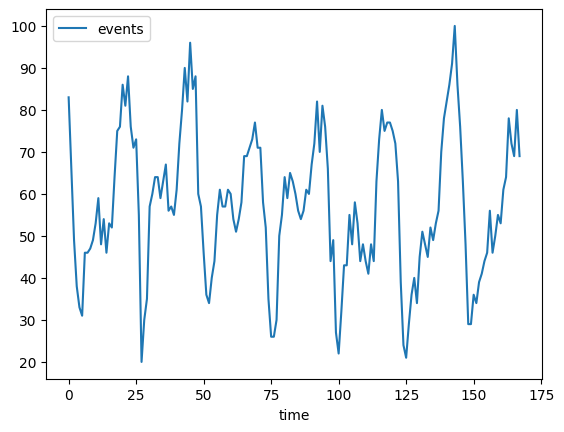

In [11]:
path = "AnneFrank.csv"
AnneFrank = pd.read_csv(path, header=1, names=['time', 'events'])
AnneFrank['date'] = pd.to_datetime(AnneFrank.time)
AnneFrank['time'] = AnneFrank['date'].astype(int) / 3600000000000
AnneFrank['time'] = AnneFrank['time'] - AnneFrank['time'].min()
AnneFrank.plot(x='time', y='events');

In this question you will fit a model to the response based on $2p+1$ predictors of the form:
$$
\begin{align}
x_1 = [1,~\ldots~,1]
\end{align}
$$
$$
\begin{align}
x_{2k} & = \sin(2 \pi \cdot k \cdot t / 48) \\
x_{2k+1} & = \cos(2 \pi \cdot k \cdot t / 48), \qquad k=1,\ldots,p
\end{align}
$$
You will then use the selected model to predict the number of events in future times.

1. Write a function ``generate_Z`` that recieves as inputs a vector of time indices (representing hours) ``t`` and ``p``. The function returns the design matrix $Z$ of size $n \times (2p+1)$, where $n$ is the length of ``t``.
2. For each $p=1,\ldots,30$, fit a linear model to ``events`` based on $Z$ you obtain from ``generate_Z`` and evalaute its leave-one-out CV error. Plot the CV error versus $p$.
3. Report on the model with the lowest CV error; plot its response over time along with the original response in the figure above.
4. Using the model you found in 3, predict the number of event at times $t=168.\ldots,190$. Plot your prediction over time in the same figure as above, i.e., interpolate the response curve to future value.
5. For each $t$ in 4, construct a 0.95 prediction interval of your prediction of $y_t$, $t=168,\ldots,190$. Plot the upper and lower limits of this interval over time (these lines define a prediction band). Here, you may ignore the danger of inference based on the t distribution after applying a model selection procedure.

Hints: (2) In order to evalaute the CV error, you'll need the hat matrix (which you can get directly from Z) and the residuals in the LS fit (which you can get from the ``resid`` property of the fitted model object returned by ``statsmodels.api.OLS.fit``). (4) you can use the function ``predict`` of the fitted model object by passing new predictors that you generate using ``generate_Z``. For (5), $s^2$ is given by the property ``mse_resid`` (or ``ssr`` divided by the number of degrees of freedom). Also note that the number of degrees of freedom is $2p+1$ where $p$ is the number you found in 3.

1.

In [12]:
def generate_Z(t, p):
  """
  Args:
  ----
  t:   vector of time samples (length n)
  p:   number of frequencies (overal 2p+1 predictors)

  Returns:
  --------
  Z:  design matrix of size (n, 2p+1)
  """
  n = len(t)
  x_1 = np.ones(n).reshape(-1, 1)
  Z = [x_1]

  for i in range(1, p+1):
    x_2i = np.array(np.sin(2 * np.pi * i * t / 48)).reshape(-1, 1)
    x_2i_1 = np.array(np.cos(2 * np.pi * i * t / 48)).reshape(-1, 1)
    Z.append(x_2i)
    Z.append(x_2i_1)

  Z = np.column_stack(Z)
  return Z

2.

In [13]:
def generate_predictions(t, p, y):
  Z = generate_Z(t, p)
  Z_p_inv = np.dot(np.linalg.inv(np.dot(Z.T, Z)), Z.T)
  H = np.dot(Z, Z_p_inv)

  beta_hat = np.dot(Z_p_inv, y)
  y_hat = np.dot(Z, beta_hat)
  return H, beta_hat, y_hat

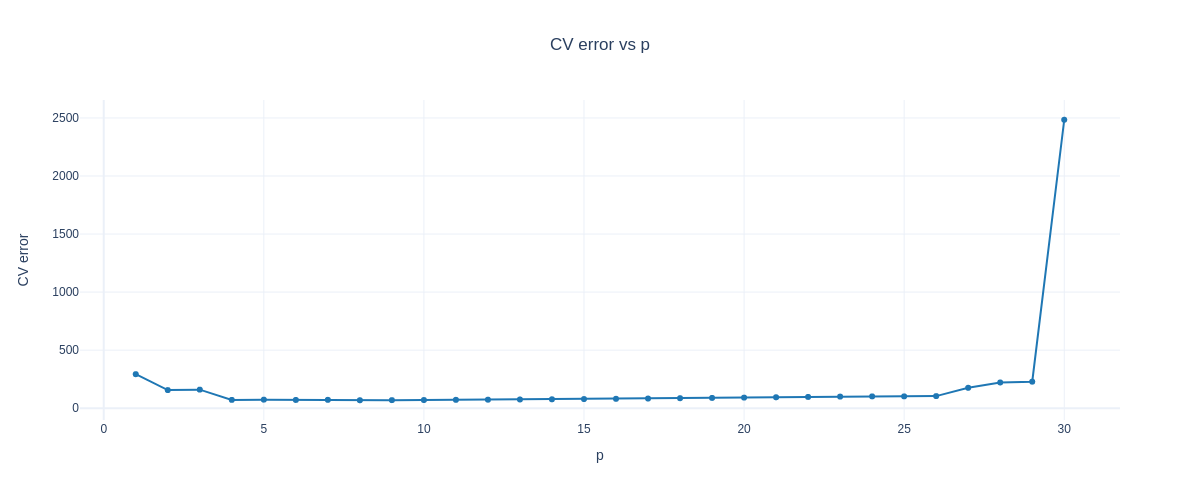

In [17]:
max_p = 30
cvs = []
y = AnneFrank['events']

for p in range(1, max_p+1):
  H, _, y_hat = generate_predictions(AnneFrank['time'], p, y)

  H_ii = H.diagonal()

  results = sm.OLS(y, y_hat).fit()
  residuals = results.resid
  sqr_errors = (residuals ** 2) / ((1 - H_ii) ** 2) #shortcut version
  cv = np.mean(sqr_errors)
  cvs.append(cv)

fig = go.Figure()

fig.add_trace(go.Scatter(
        x=list(range(1, max_p+1)),
        y=cvs,
        mode='lines+markers',
        name=r'CV error',
        line=dict(color='#1f77b4'),
    ))

fig.update_layout(
        height=500, width=1200,
        title=dict(text=f"CV error vs p", x=0.5),
        xaxis_title=f'p',
        yaxis_title=f'CV error',
        template='plotly_white',
        legend=dict(orientation='h', x=.5, y=1, xanchor='center', yanchor='bottom')
    )

fig.show(renderer='png')


3.


In [18]:
print(f'The model with the lowest CV error is the model with p = {np.argmin(cvs) + 1}.')

The model with the lowest CV error is the model with p = 8.


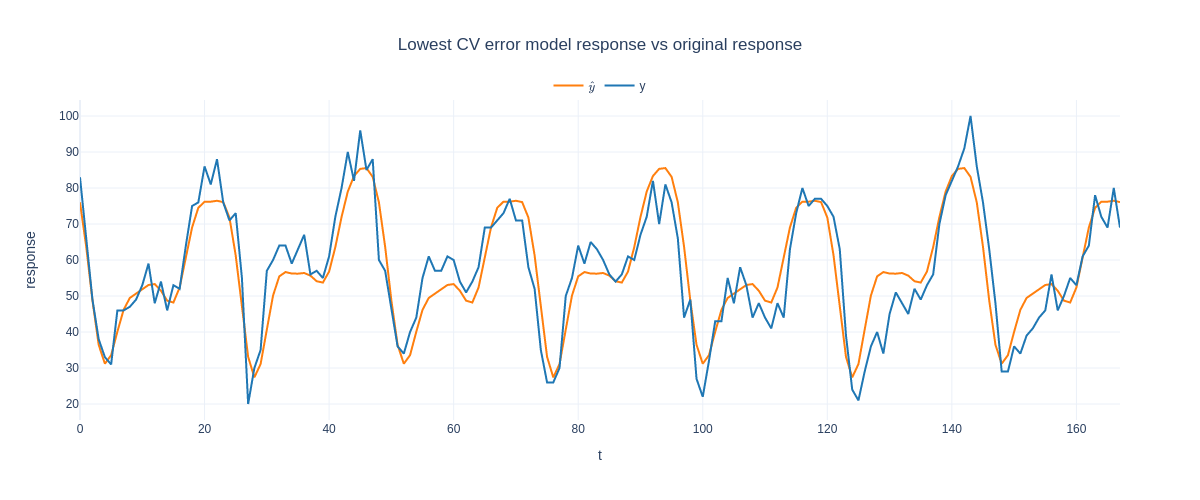

In [19]:
p = 8
_, beta_hat, y_hat = generate_predictions(AnneFrank['time'], p, y)

fig = go.Figure()

fig.add_trace(go.Scatter(
        x=list(range(len(y))),
        y=y_hat,
        mode='lines',
        name = r'$\hat{y}$',
        line=dict(color='#ff7f0e'),
    ))

fig.add_trace(go.Scatter(
        x=list(range(len(y))),
        y=y,
        mode='lines',
        name = 'y',
        line=dict(color='#1f77b4'),
    ))

fig.update_layout(
        height=500, width=1200,
        title=dict(text=f"Lowest CV error model response vs original response", x=0.5),
        xaxis_title=f't',
        yaxis_title=f'response',
        template='plotly_white',
        legend=dict(orientation='h', x=.5, y=1, xanchor='center', yanchor='bottom')
    )

fig.show(renderer='png')


4.

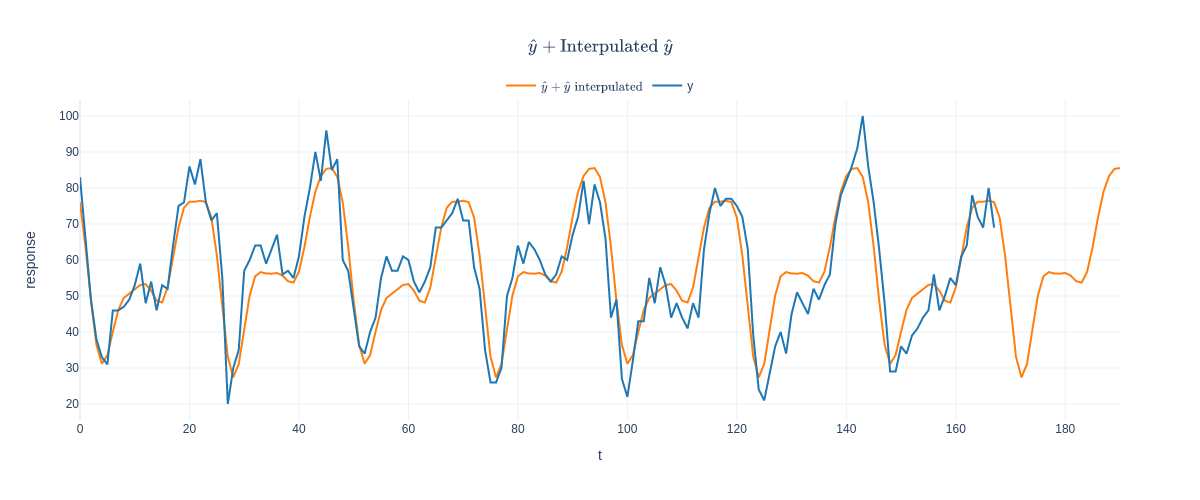

In [20]:
interp_t = np.arange(168, 191)
interp_Z = generate_Z(interp_t, p)
interp_y_hat = np.dot(interp_Z, beta_hat)

fig = go.Figure()

fig.add_trace(go.Scatter(
        x=list(range(len(y)+len(interp_y_hat))),
        y=np.append(y_hat, interp_y_hat),
        mode='lines',
        name = r'$\hat{y} + \hat{y} \; \text{interpulated}$',
        line=dict(color='#ff7f0e'),
    ))

fig.add_trace(go.Scatter(
        x=list(range(len(y))),
        y=y,
        mode='lines',
        name = 'y',
        line=dict(color='#1f77b4'),
    ))

fig.update_layout(
        height=500, width=1200,
        title=dict(text=r"$\hat{y} + \text{Interpulated} \;\hat{y}$", x=0.5),
        xaxis_title=f't',
        yaxis_title=f'response',
        template='plotly_white',
        legend=dict(orientation='h', x=.5, y=1, xanchor='center', yanchor='bottom')
    )

fig.show(renderer='png')

5.

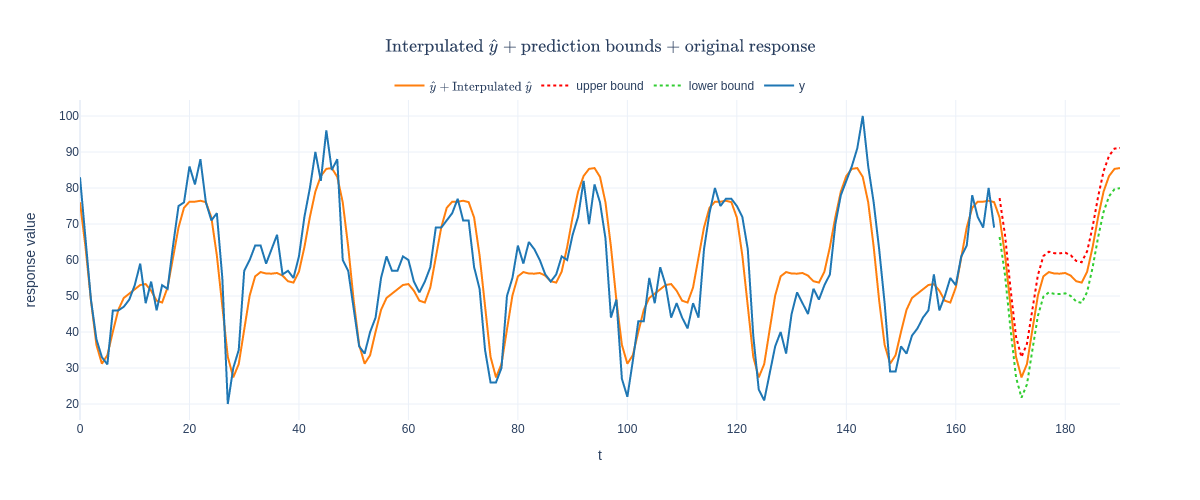

In [21]:
ALPHA = 0.05
n = len(y)
dof = 2 * p + 1
t_statistic = t_test.ppf(1 - ALPHA / 2, dof)

residuals = y - y_hat
s = np.sqrt(np.dot(residuals, residuals) / (n - dof))
min_cv_error_Z = generate_Z(AnneFrank['time'], p)
upper_bands, lower_bands = list(), list()

for index, row in enumerate(interp_Z):
    single_sample = row.reshape(-1, 1)
    s_multiplayer = np.sqrt(np.dot(np.dot(single_sample.T, np.linalg.inv(np.dot(min_cv_error_Z.T, min_cv_error_Z))), single_sample))

    # get the lower and upper bands
    band = t_statistic * s * s_multiplayer
    upper_band = interp_y_hat[index] + band
    lower_band = interp_y_hat[index] - band

    upper_bands.append(upper_band[0][0])
    lower_bands.append(lower_band[0][0])

fig = go.Figure()

fig.add_trace(go.Scatter(
        x=list(range(len(y)+len(interp_y_hat))),
        y=np.append(y_hat, interp_y_hat),
        mode='lines',
        name = r'$\hat{y} + \text{Interpulated} \;\hat{y}$',
        line=dict(color='#ff7f0e'),
    ))

fig.add_trace(go.Scatter(
        x=list(interp_t),
        y=upper_bands,
        mode='lines',
        name = 'upper bound',
        line=dict(color='#ff0000', dash = 'dot'),
    ))

fig.add_trace(go.Scatter(
        x=list(interp_t),
        y=lower_bands,
        mode='lines',
        name = 'lower bound',
        line=dict(color='#32cd32', dash = 'dot'),
    ))

fig.add_trace(go.Scatter(
        x=list(range(len(y))),
        y=y,
        mode='lines',
        name = 'y',
        line=dict(color='#1f77b4'),
    ))

fig.update_layout(
        height=500, width=1200,
        title=dict(text=r"$\text{Interpulated} \;\hat{y} + \text{prediction bounds + original response}$", x=0.5),
        xaxis_title=f't',
        yaxis_title=f'response value',
        template='plotly_white',
        legend=dict(orientation='h', x=.5, y=1, xanchor='center', yanchor='bottom')
    )

fig.show(renderer='png')


fig = go.Figure()

fig.add_trace(go.Scatter(
        x=list(interp_t),
        y=interp_y_hat,
        mode='lines+markers',
        name = r'$\text{Interpulated} \; \hat{y}$',
        line=dict(color='#1f77b4'),
    ))

fig.add_trace(go.Scatter(
        x=list(interp_t),
        y=upper_bands,
        mode='lines+markers',
        name = 'upper bound',
        line=dict(color='#ff0000', dash = 'dot'),
    ))

fig.add_trace(go.Scatter(
        x=list(interp_t),
        y=lower_bands,
        mode='lines+markers',
        name = 'lower bound',
        line=dict(color='#32cd32', dash = 'dot'),
    ))


fig.update_layout(
        height=500, width=1200,
        title=dict(text=r"$\text{Interpulated} \;\hat{y} + \text{prediction bounds}$", x=0.5),
        xaxis_title=f't',
        yaxis_title=f'response value',
        template='plotly_white',
        legend=dict(orientation='h', x=.5, y=1, xanchor='center', yanchor='bottom')
    )

fig.show()

## Problem 3 (Violation of Assumptions)

In this problem you work with the model you fitten in Problem 2 to the data ``AnneFrank``. Make sure you used ``statsmodels`` and printed the model diagnostic information, e.g. using ``model.summary()``
1. What can you say about the assumption that the residuals follow a normal distribution? which statistic provides relevant information?
2. Plot the model residuals over time. Make a 1-lag residuals plot $\hat{\epsilon}_{i+1}$ vs. $\hat{\epsilon}_{i}$). Do the residual look dependent over time or not? which statistic provide relevant inforamtion?
3. A Fourier analysis reveals that there exist dominant periodic components of time period $20$ hours and $30$ hours in the residuals (you don't have to do the analysis). Argue that this is the case by regressing the residuals over the predictors $x1 = \cos(2\pi t/20)$, $x2 = \sin(2\pi t/20)$, $x3 = \cos(2\pi t/30)$ and $x4 = \sin(2\pi t/30)$, $t=1,\ldots,167$. Indicate how you can deduce that the new model makes sense.
4. What can you say about the 1-lag correlation of the residuals of the new model?


In [22]:
Z_df = pd.DataFrame(min_cv_error_Z)
Z_df = Z_df.add_prefix('col_')
formula = f"events ~ {' + '.join(Z_df.columns)}"
Z_df['events'] = y
ft = smf.ols(formula, Z_df).fit()

ft.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 events   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.788
Method:                 Least Squares   F-statistic:                     39.82
Date:                Tue, 20 Jun 2023   Prob (F-statistic):           6.06e-46
Time:                        06:01:14   Log-Likelihood:                -574.77
No. Observations:                 168   AIC:                             1184.
Df Residuals:                     151   BIC:                             1237.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     28.7367      0.304     94.426      0.000      28.135      29.338
col_0         28.7367      0.304     94.426      0.000      28.135      29.338
col_1         -2.2939      0.861     -2.664      0.009      -3.995      -0.592
col_2          2.1491      0.860      2.498      0.014       0.449       3.849
col_3        -15.1803      0.861    -17.628      0.000     -16.882     -13.479
col_4          6.6888      0.860      7.775      0.000       4.989       8.389
col_5         -0.0428      0.861     -0.050      0.960      -1.744       1.659
col_6          0.9642      0.860      1.121      0.264      -0.736       2.664
col_7        -12.1765      0.861    -14.142      0.000     -13.878     -10.475
col_8          4.4746      0.860      5.202      0.000       2.775       6.174
col_9         -0.1944      0.861     -0.226      0.822      -1.896       1.507
col_10        -0.3186      0.860     -0.370      0.712      -2.018       1.381
col_11        -0.1140      0.861     -0.133      0.895      -1.815       1.586
col_12         2.8395      0.860      3.302      0.001       1.141       4.538
col_13        -0.9084      0.861     -1.056      0.293      -2.609       0.792
col_14        -0.6877      0.860     -0.800      0.425      -2.387       1.011
col_15         1.7811      0.857      2.078      0.039       0.087       3.475
col_16         2.4311      0.856      2.840      0.005       0.740       4.123
==============================================================================
Omnibus:                        2.459   Durbin-Watson:                   0.816
Prob(Omnibus):                  0.293   Jarque-Bera (JB):                2.318
Skew:                          -0.288   Prob(JB):                        0.314
Kurtosis:                       2.978   Cond. No.                     3.54e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.7e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

1. According to Jarque-Bera (JB) test value the residuals follow a normal distribution, furthermore we can see it in the qq-plot as well - the residuals follows a straight $45°$ line

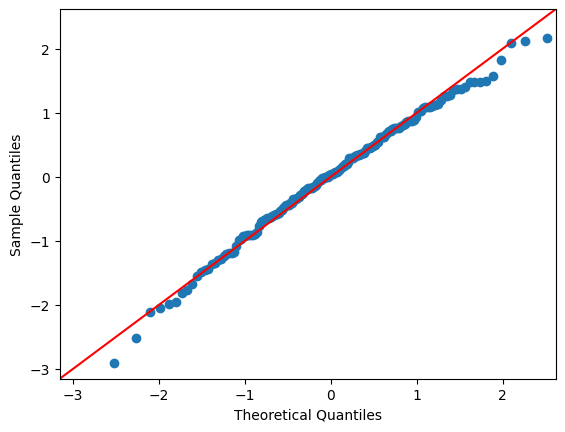

In [23]:
sm.qqplot(ft.resid / np.sqrt(ft.mse_resid) , line ='45')
plt.show()

2. According to Durbin-Watson test the residuals are positively correlated (DW < 2), this is confirmed by the graph below

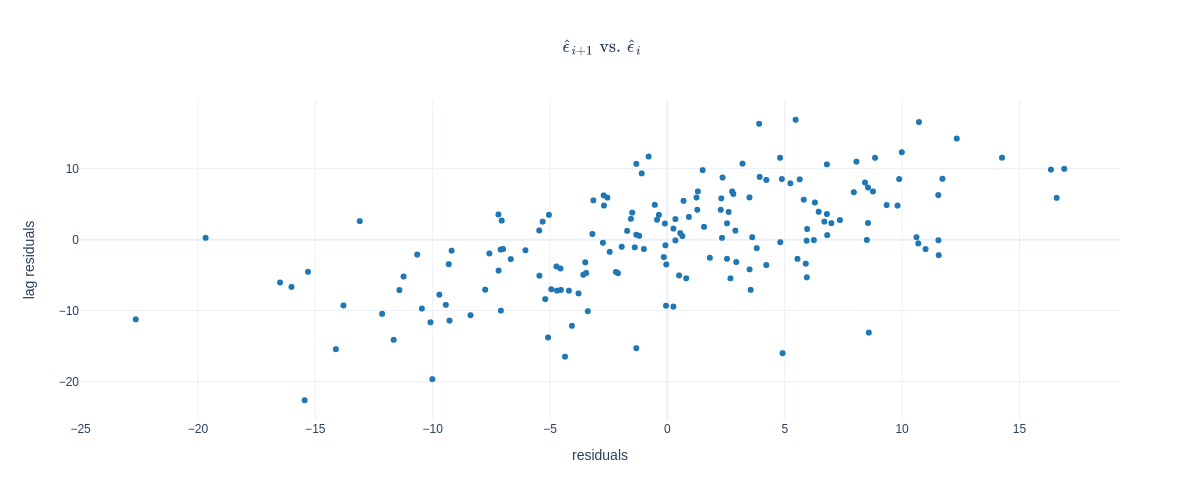

In [24]:
residuals = ft.resid
lag_residuals = residuals[1:]

fig = go.Figure()

fig.add_trace(go.Scatter(
        x=residuals[:-1],
        y=lag_residuals,
        mode='markers',
        line=dict(color='#1f77b4'),
    ))

fig.update_layout(
        height=500, width=1200,
        title=dict(text=r"$\hat{\epsilon}_{i+1}\; \text{vs.}\; \hat{\epsilon}_{i}$", x=0.5),
        xaxis_title=f'residuals',
        yaxis_title=f'lag residuals',
        template='plotly_white',
        legend=dict(orientation='h', x=.5, y=1, xanchor='center', yanchor='bottom')
    )

fig.show(renderer='png')

3.

In [25]:
t = AnneFrank['time']
Z = []

x_1 = np.array(np.cos(2 * np.pi * t / 20))
x_2 = np.array(np.sin(2 * np.pi * t / 20))
x_3 = np.array(np.cos(2 * np.pi * t / 30))
x_4 = np.array(np.sin(2 * np.pi * t / 30))
Z.append(x_1.reshape(-1, 1))
Z.append(x_2.reshape(-1, 1))
Z.append(x_3.reshape(-1, 1))
Z.append(x_4.reshape(-1, 1))

Z = np.column_stack(Z)

fourier_analysis_predictors_df = pd.DataFrame({'x_1': x_1, 'x_2': x_2, 'x_3': x_3, 'x_4': x_4})
formula = f"events ~ {' + '.join(fourier_analysis_predictors_df.columns)}"
fourier_analysis_predictors_df['events'] = y
fourier_analysis_ft = smf.ols(formula, fourier_analysis_predictors_df).fit()

fourier_analysis_ft.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 events   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                     6.280
Date:                Tue, 20 Jun 2023   Prob (F-statistic):           0.000100
Time:                        06:01:15   Log-Likelihood:                -701.53
No. Observations:                 168   AIC:                             1413.
Df Residuals:                     163   BIC:                             1429.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     57.3417      1.239     46.270      0.000      54.895      59.789
x_1            6.2967      1.755      3.588      0.000       2.831       9.762
x_2            2.3369      1.745      1.339      0.182      -1.109       5.783
x_3           -1.0556      1.735     -0.608      0.544      -4.483       2.371
x_4           -5.1067      1.768     -2.889      0.004      -8.597      -1.616
==============================================================================
Omnibus:                        1.052   Durbin-Watson:                   0.330
Prob(Omnibus):                  0.591   Jarque-Bera (JB):                1.072
Skew:                          -0.081   Prob(JB):                        0.585
Kurtosis:                       2.644   Cond. No.                         1.49
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

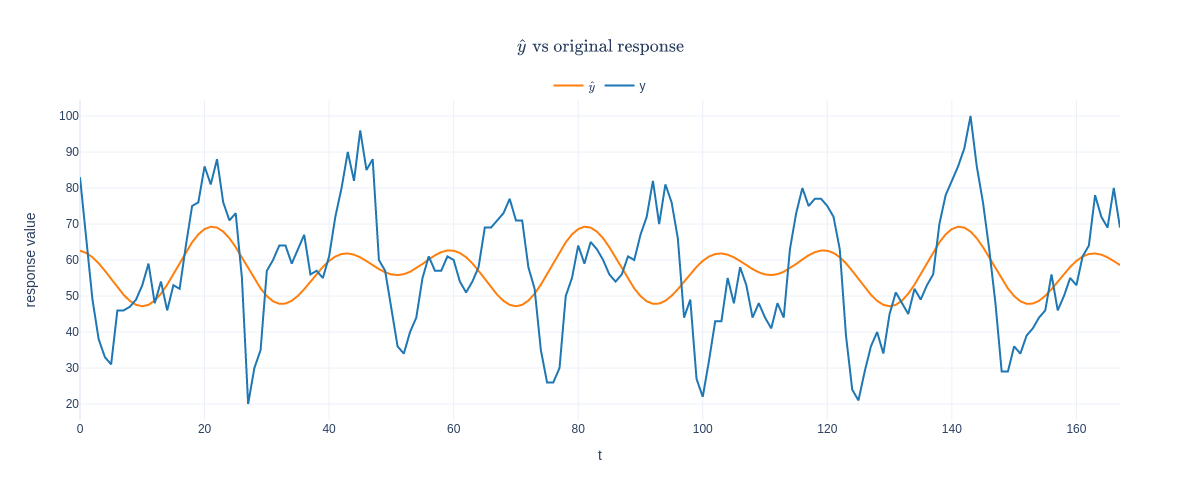

In [26]:
fig = go.Figure()

fig.add_trace(go.Scatter(
        x=list(range(len(y))),
        y=fourier_analysis_ft.predict(fourier_analysis_predictors_df),
        mode='lines',
        name = r'$\hat{y}$',
        line=dict(color='#ff7f0e'),
    ))

fig.add_trace(go.Scatter(
        x=list(range(len(y))),
        y=y,
        mode='lines',
        name = 'y',
        line=dict(color='#1f77b4'),
    ))

fig.update_layout(
        height=500, width=1200,
        title=dict(text=r"$\hat{y} \; \text{vs original response}$", x=0.5),
        xaxis_title=f't',
        yaxis_title=f'response value',
        template='plotly_white',
        legend=dict(orientation='h', x=.5, y=1, xanchor='center', yanchor='bottom')
    )

fig.show(renderer='png')

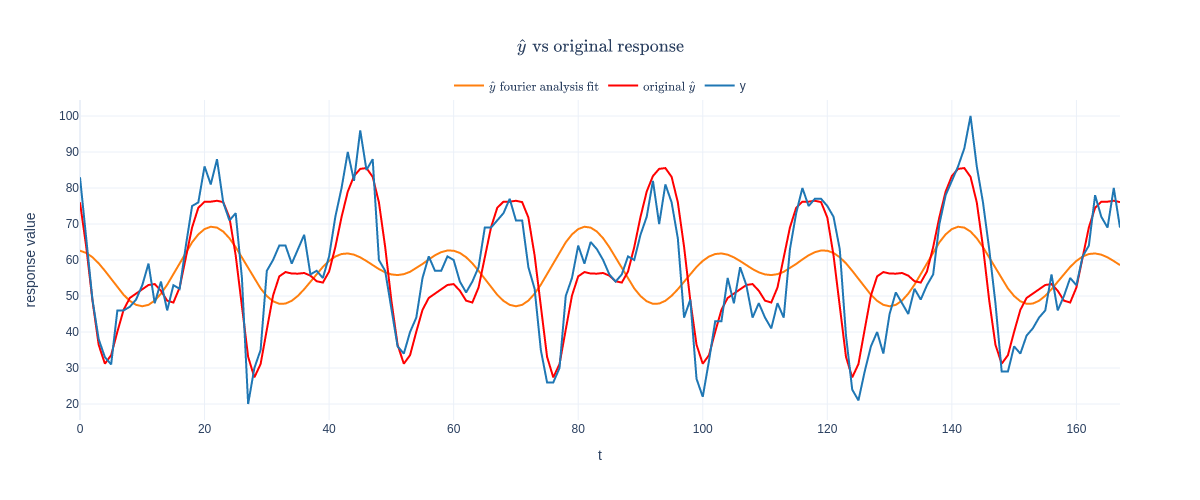

In [27]:
fig = go.Figure()

fig.add_trace(go.Scatter(
        x=list(range(len(y))),
        y=fourier_analysis_ft.predict(fourier_analysis_predictors_df),
        mode='lines',
        name = r'$\hat{y} \; \text{fourier analysis fit}$',
        line=dict(color='#ff7f0e'),
    ))

fig.add_trace(go.Scatter(
        x=list(range(len(y))),
        y=y_hat,
        mode='lines',
        name = r'$\text{original} \; \hat{y}$',
        line=dict(color='#ff0000'),
    ))

fig.add_trace(go.Scatter(
        x=list(range(len(y))),
        y=y,
        mode='lines',
        name = 'y',
        line=dict(color='#1f77b4'),
    ))

fig.update_layout(
        height=500, width=1200,
        title=dict(text=r"$\hat{y} \; \text{vs original response}$", x=0.5),
        xaxis_title=f't',
        yaxis_title=f'response value',
        template='plotly_white',
        legend=dict(orientation='h', x=.5, y=1, xanchor='center', yanchor='bottom')
    )

fig.show(renderer='png')

Visually, this model is inferior of our previous model, and we can use the following test to deduce that the new model makes sense (p value is extremly low hence the first model is prefferable)

In [28]:
sm.stats.anova_lm(fourier_analysis_ft, ft)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,163.0,41672.620963,0.0,NaN,NaN,NaN
1,151.0,9214.820350,12.0,32457.800613,44.322874,2.400381e-43


4. According to Durbin-Watson test the residuals are positively correlated, even more positively correlated than the ones in our previous model (DW 0.816 vs DW 0.33), this is confirmed by the graph below

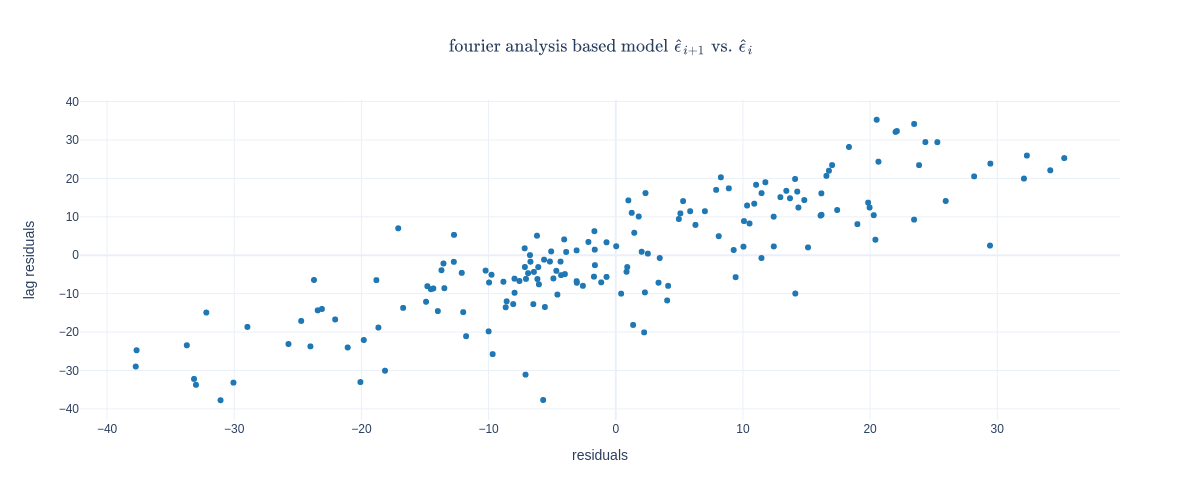

In [29]:
residuals = fourier_analysis_ft.resid
lag_residuals = residuals[1:]

fig = go.Figure()

fig.add_trace(go.Scatter(
        x=residuals[:-1],
        y=lag_residuals,
        mode='markers',
        line=dict(color='#1f77b4'),
    ))

fig.update_layout(
        height=500, width=1200,
        title=dict(text=r"$\text{fourier analysis based model} \; \hat{\epsilon}_{i+1}\; \text{vs.}\; \hat{\epsilon}_{i}$", x=0.5),
        xaxis_title=f'residuals',
        yaxis_title=f'lag residuals',
        template='plotly_white',
        legend=dict(orientation='h', x=.5, y=1, xanchor='center', yanchor='bottom')
    )

fig.show(renderer='png')